# Use of Machine Learning Algorithms to classify croplands

## Group #02
<b>Group members:<br></b> <b>
    <em>
        1.	Mustafa Kamal Shahadat, Scientific Officer, On-Farm Research Division, BARI<br>
        2.	Ummy Kulsum, Scientific Officer, Oilseed Research Center, BARI<br>
        3.	Istiak Ahmed, Scientific Officer, Agricultural Statistics &amp; ICT Division, BARI<br>
        </em></b>

## 1. Introduction

### 1.1. Background

<p style="text-align: justify"> Cropland classification is an essential step in agricultural planning and management activities at national and global scales. The crop map plays an important role in various applications such as crop inventories, crop insurance, yield estimation, and the enforcement of quota limits. Earth observation technology makes use of optical sensors with various spatial and temporal resolutions. Observations from these sensors can be used for agricultural land classification in a more efficient manner and with lower costs than the traditional survey method. The most widely used optical sensors are the Moderate Resolution Imaging Spectroradiometer (MODIS), Landsat, NOAA and IRS sensors, due to their higher revisit time. Diverse classification algorithms with a different nature and architecture have already been proposed for crop mapping. Some studies have used Bayesian networks or the maximum likelihood method, which are traditional and parametric, i.e., they strongly depend on data distribution. Therefore, they may be limited
in the classification of big data. Some other studies have used nonparametric methods, such as artificial neural networks (ANN), random forest (RF), support vector machines (SVM), Gradient Boosting Machine (GBM). In this project, temporal observations of optical data have been roposed for crop mapping using RF and LightGBM machine learning algorithms.</p>

### 1.2. Objectives of the study
<p style="text-align: justify">Two major objectives of this study are:</p>
<ol>
    <li style="text-align: justify">Accessing satellite imegary using Google Earth Engine (GEE) through Python;</li>
    <li style="text-align: justify">Using DASK distributed platform for learning purpose;</li>
    <li style="text-align: justify">Assess the performance of scikit-learn's Random Forest Classifier;</li>
    <li style="text-align: justify">Investigate potential performance improvements that may be offered by an Support Vector Machine (SVM).</li>
</ol>

## 2. Method

### 2.1. The data description

<p style="text-align: justify"><b><em>Satellite data:</em> </b>This study used the data of satellite imagery (Sentinel-2) of Trans Nzoia county, Kenya from Google Earth Engine on 2 May, 2019.</p>

<p style="text-align: justify"><b><em>Ground truth data:</em> </b>The reference data were collected which can be accessed from <a href="https://drive.google.com/drive/folders/1jM2mBsJ81QfmyaKZNeXSTyi_IOVr_3Vs?usp=sharing">here</a>. This is the prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over..<p>
<p style="text-align: justify">The dataset has 160,461 observations.</p>

### Setup Notebook

In [71]:
# Requirements, will skip if already installed
%pip install geopandas rasterio rasterstats shapely
%pip install folium earthengine-api
%pip install scikit-learn
%pip install treeinterpreter

In [72]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

### Connect Google Drive

In [73]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [74]:
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/My Drive/Colab Notebooks/data"

## Label data preparation

We will be using an already prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over.



In [114]:
# read in training data polygons that created as geojson from a shared directory
training_data = '/content/drive/My Drive/Colab Notebooks/data/training_data.geojson'
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()

,name,description,geometry
0,Shadow,None,"MULTIPOLYGON (((34.83383 1.18204, 34.83577 1.1..."
1,Forestland,None,"MULTIPOLYGON (((35.30961 1.01328, 35.30964 1.0..."
2,Maize,early reproductive,"MULTIPOLYGON (((34.90904 1.09515, 34.90907 1.0..."
3,Sugarcane,no change..maize farm on the right and far lef...,"MULTIPOLYGON (((34.90750 1.08934, 34.90753 1.0..."
4,Maize,reproductive good crop,"MULTIPOLYGON (((34.87144 0.82953, 34.87147 0.8..."


## Reading imagery from Google Earth Engine (GEE)

For this example we will be using Google Earth Engine to select and filter Satellite imagery that we will classify with the training data.

### Connect to GEE

In [77]:
# If not on Colab you'll need install the earth-engine Python API
#!pip install earthengine-api #earth-engine Python API

# Athenticate to your GEE account. 
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=GBeuND50Pqd3xvKtB-m_5V9XUIAArB3lkYGqUSD2zn4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWincDGtpG48iMGg0ylq08GQ52jxmk1Wt-nuHB2nXBJUdn4_JZIzZv0

Successfully saved authorization token.


In [78]:
# Earth Engine Python API
import ee 
ee.Initialize()

### Search GEE Data

We will now search for Sentinel 2 imagery, a multispectral satellite with ~10m resolution and repeat coverage every 5 days.

Filters will include selecting bands, a date range, and only imagery within a defined Area of Interest (AOI).

In [79]:
# From GEE
#training_vectors.total_bounds.tolist()
aoi = ee.Geometry.Rectangle(training_vectors.total_bounds.tolist())
band_sel = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(aoi)\
    .filterDate('2019-05-02', '2019-05-03')\
    .select(band_sel)

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

sentinel_mosaic.getInfo()

COPERNICUS/S2/20190502T074621_20190502T080204_T36NXF
COPERNICUS/S2/20190502T074621_20190502T080204_T36NXG
COPERNICUS/S2/20190502T074621_20190502T080204_T36NYF
COPERNICUS/S2/20190502T074621_20190502T080204_T36NYG


{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B2'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B3'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B4'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B8'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'B11'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 

In [ ]:
# To make a map we first need some helper functions

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if gpd.geodataframe.GeoDataFrame == type(v):
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz) 
      elif ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [ ]:
s2_vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}

Mapdisplay(center=[center.y, center.x],
           dicc={'S2':sentinel_mosaic.getMapId(s2_vis_params),
                 'TrainingData':training_vectors}, 
           zoom_start=12)


### Exporting Image

Since our analysis method in this example will happen outside of Google Earth Engine we will be exporting the search results to a Cloud Optimized Geotiff, a common GIS format for rasters. This will highlight that you can get imagery from any data source for this type of analysis.

In [ ]:
# We will save it to Google Drive for later reuse
raster_name = op.join(my_root_dir,'sentinel_mosaic-Trans_Nzoia')

In [ ]:
# Export the image, specifying scale and region.
# Warning, This specific export takes at least 1 hour, and 700+ MB
# There may be a bug here, not sure GEE export can write to a folder beyond depth 1 in a google drive
task = ee.batch.Export.image.toDrive(**{
    'image': sentinel_mosaic,
    'description': 'Trans_nzoia_2019_05_02',
    'folder': my_root_dir,
    'fileNamePrefix': raster_name,
    'scale': 10,
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

# This task will run in the background even if you close this notebook.
# You can also check on the status of the task through the Javascript GEE interface
# https://code.earthengine.google.com
task.start()

In [ ]:
# If you want to keep track of the export you can run this code
# However if run this, you will need to wait for it to finish before running additional code

import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(15)

Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id: P7MBTWVPHH7JDA2RO6RSONGG).
Polling for task (id

In [80]:
# Reference the raster on disk.
# raster_path = op.join(my_root_dir, raster_name)
# raster_file = ".".join([raster_path, "tif"])
# Alternate reference already prepared file on Google Drive, uncomment next line to use
raster_file = '/content/drive/My Drive/Colab Notebooks/data/Trans_nzoia_2019_05-02.tif'

print(raster_file)

/content/drive/My Drive/Colab Notebooks/data/Trans_nzoia_2019_05-02.tif


## Model training

Now we're going to work on training a model to identify classes of land use based on the training data and the satellite imagery.

### Prepare Data

First we will need to do some preparation to organize the training data into the correct python types, and to extract sample pixels from the intersecting imagery.

In [81]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.name)
classes

array(['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize',
       'Shadow', 'Sugarcane', 'Sunflower', 'Waterbody'], dtype=object)

In [82]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict                  

{'Built': 0,
 'Cloud': 1,
 'Fallow': 2,
 'Forestland': 3,
 'Grassland': 4,
 'Maize': 5,
 'Shadow': 6,
 'Sugarcane': 7,
 'Sunflower': 8,
 'Waterbody': 9}

In [ ]:
class_share = pd.Series(100 * training_vectors.name.value_counts(normalize=True)).sort_index()
print('Class share\n')
for i in range(0,9):
    print(f'Class {class_share.index[i]}: {class_share.iloc[i]:.2f} %')

Class share

Class Built: 1.12 %
Class Cloud: 0.64 %
Class Fallow: 0.96 %
Class Forestland: 6.57 %
Class Grassland: 1.60 %
Class Maize: 85.74 %
Class Shadow: 0.48 %
Class Sugarcane: 1.60 %
Class Sunflower: 0.16 %


Text(0, 0.5, 'Share (%)')

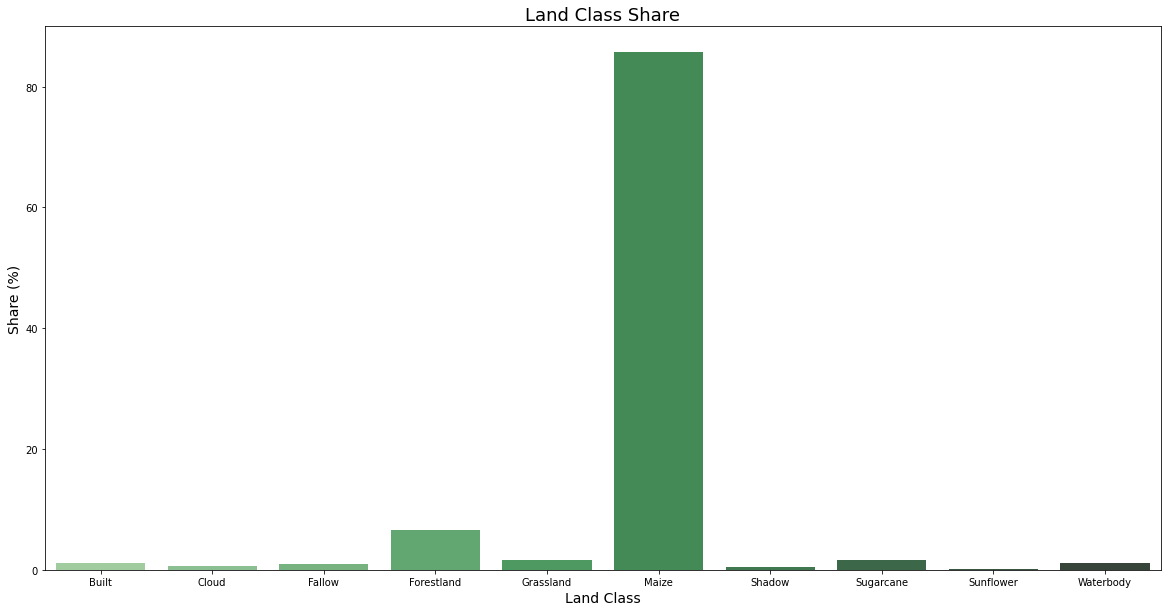

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(ax=ax, x = ['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize','Shadow','Sugarcane','Sunflower','Waterbody'], 
            y = class_share, palette='Greens_d')
plt.title('Land Class Share', fontsize=18)
plt.xlabel('Land Class', fontsize=14)
plt.ylabel('Share (%)', fontsize=14)

This section loops through the training classes and their polygons reading the imagery raster extracting values.

In [83]:
# raster information

##If you want to read the data directly from the shared folder, uncomment the following line.
# raster_file = '/content/drive/Shared drives/servir-sat-ml/data/Trans_nzoia_2019_05-02.tif'


# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [84]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((160461, 6), (160461,))

In addition to the raw pixel values we will calculated a couple of indices that help in some classifications.
* [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) - great for identiying photosynthesizing plants.
* [Normalized Difference Water Index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index) - great for identifying open water (when there isn't a lot of glare)

In [85]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(160461, 8)

In [86]:
%pip install dask[dataframe] --upgrade

## ESDA using DASK

In [ ]:
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
import dask.array as da

In [ ]:
c1 = da.from_array(X)
c2 = da.from_array(y)

In [ ]:
df = dd.concat([dd.from_dask_array(c) for c in [c1,c2]], axis = 1)

In [ ]:
df.columns = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'land']
df

,B2,B3,B4,B8,B11,B12,NDVI,NDWI,land
npartitions=1,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,float64,int64
160460,...,...,...,...,...,...,...,...,...


In [ ]:
dfSland = df.set_index('land')

In [ ]:
dfSland.head()

,B2,B3,B4,B8,B11,B12,NDVI,NDWI
land,,,,,,,,
0,0.1026,0.1178,0.1752,0.2052,0.3184,0.2768,0.078864,-0.270588
0,0.1157,0.1303,0.1749,0.2163,0.3006,0.2561,0.105828,-0.248125
0,0.1092,0.1207,0.1578,0.2067,0.3001,0.2497,0.134156,-0.262676
0,0.1081,0.1131,0.1446,0.1877,0.3001,0.2497,0.129702,-0.248005
0,0.1156,0.1196,0.1511,0.1846,0.2664,0.2294,0.099791,-0.213675


In [ ]:
dfSland.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, B2 to NDWI
dtypes: float64(8)

In [124]:
dbn = dfSland.describe()
dbn.compute()

,B2,B3,B4,B8,B11,B12,NDVI,NDWI
count,160461.000000,160461.000000,160461.000000,160461.000000,160461.000000,160461.00000,160461.000000,160461.000000
mean,0.087294,0.084988,0.090919,0.206981,0.212398,0.14420,0.385120,-0.403892
std,0.014204,0.019110,0.038209,0.052348,0.073288,0.06483,0.226427,0.130601
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.00100,-0.172603,-0.729887
25%,0.076800,0.071200,0.054000,0.163200,0.152900,0.07980,0.160813,-0.529836
50%,0.084200,0.080300,0.091200,0.212900,0.199150,0.15145,0.354988,-0.383070
75%,0.093300,0.092500,0.114700,0.247400,0.253200,0.19070,0.624677,-0.292414
max,0.303000,0.310900,0.351850,0.452800,0.497200,0.41470,0.831421,0.235772


In [ ]:
(len(df), df.shape[1])

(160461, 9)

In [ ]:
list(dfSland.columns)

['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI']

In [ ]:
dfSland.head()

,B2,B3,B4,B8,B11,B12,NDVI,NDWI
land,,,,,,,,
0,0.1026,0.1178,0.1752,0.2052,0.3184,0.2768,0.078864,-0.270588
0,0.1157,0.1303,0.1749,0.2163,0.3006,0.2561,0.105828,-0.248125
0,0.1092,0.1207,0.1578,0.2067,0.3001,0.2497,0.134156,-0.262676
0,0.1081,0.1131,0.1446,0.1877,0.3001,0.2497,0.129702,-0.248005
0,0.1156,0.1196,0.1511,0.1846,0.2664,0.2294,0.099791,-0.213675


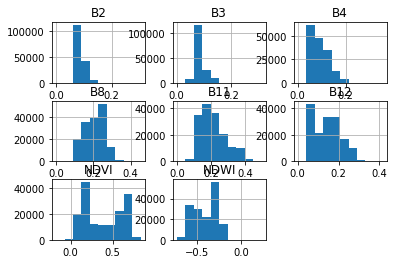

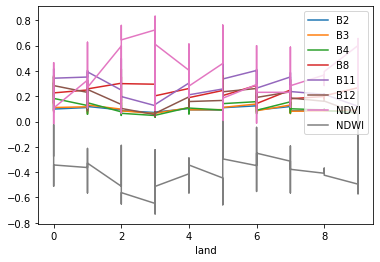

In [ ]:
x = dfSland.compute()
x.hist()
x.plot()
plt.show()

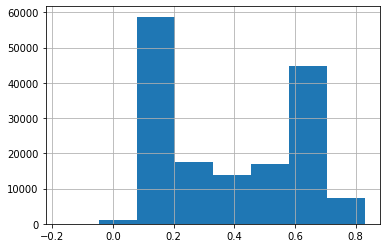

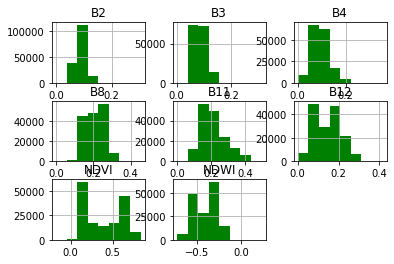

In [ ]:
x['NDVI'].hist(bins=8)
x.hist(bins=8,color='g')

plt.show()

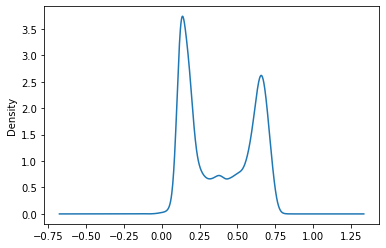

In [ ]:
x['NDVI'].plot(kind='kde')
plt.show()

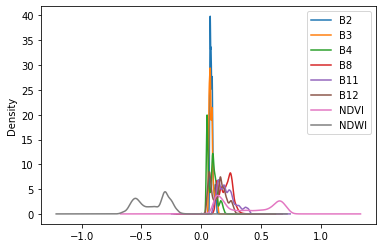

In [ ]:
x.plot(kind='kde')
plt.show()

In [ ]:
a = dfSland['NDVI'].groupby('land').size().compute()
a

land
0     2700
1      762
2     2520
3    63493
4     1475
5    79638
6     5083
7     4373
8       22
9      395
Name: NDVI, dtype: int64

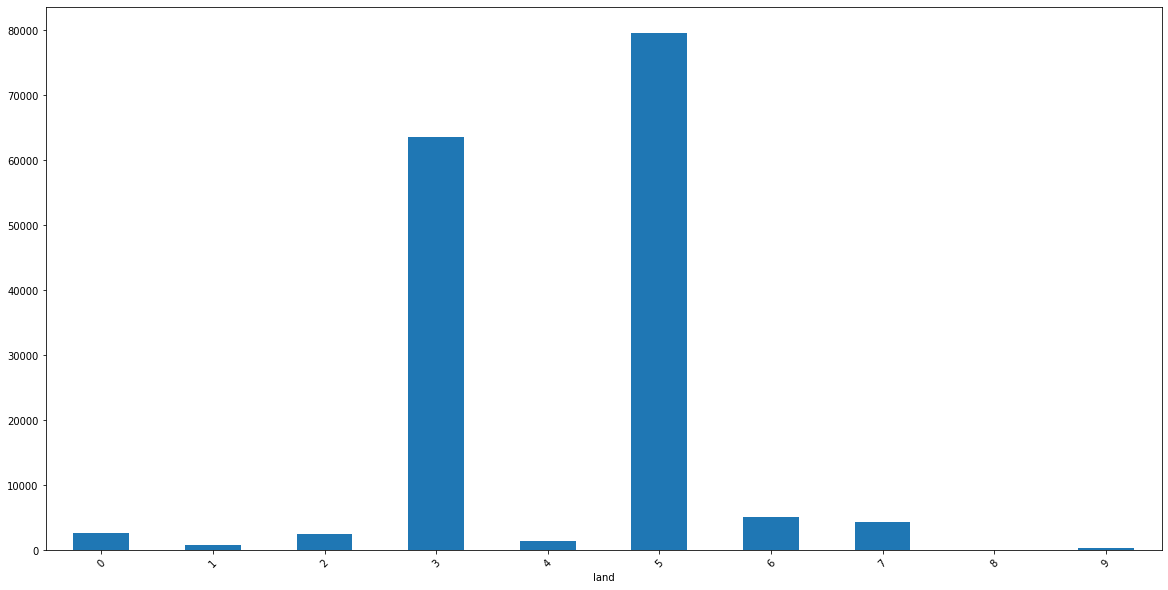

In [ ]:
a.plot(kind='bar',figsize=(20,10), rot=45)
plt.show()

In [ ]:
x5 = dfSland.cov()
x6 = dfSland.corr()
cov, corr = dask.compute(x5, x6)
print(cov)
print('\n')
print(corr)

            B2        B3        B4  ...       B12      NDVI      NDWI
B2    0.000202  0.000266  0.000481  ...  0.000780 -0.001877  0.001032
B3    0.000266  0.000365  0.000642  ...  0.001032 -0.002308  0.001237
B4    0.000481  0.000642  0.001460  ...  0.002303 -0.007141  0.003668
B8    0.000035  0.000135 -0.000454  ... -0.000945  0.008475 -0.005306
B11   0.000951  0.001287  0.002441  ...  0.004443 -0.009934  0.005242
B12   0.000780  0.001032  0.002303  ...  0.004203 -0.011933  0.006397
NDVI -0.001877 -0.002308 -0.007141  ... -0.011933  0.051269 -0.028589
NDWI  0.001032  0.001237  0.003668  ...  0.006397 -0.028589  0.017057

[8 rows x 8 columns]


            B2        B3        B4  ...       B12      NDVI      NDWI
B2    1.000000  0.979712  0.885696  ...  0.847275 -0.583730  0.556098
B3    0.979712  1.000000  0.879892  ...  0.832809 -0.533300  0.495705
B4    0.885696  0.879892  1.000000  ...  0.929774 -0.825437  0.735046
B8    0.047434  0.134449 -0.226925  ... -0.278501  0.715025 -0.776

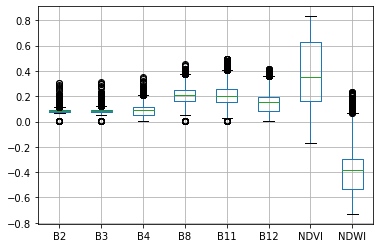

In [ ]:
dfSland.compute().boxplot()
plt.show()

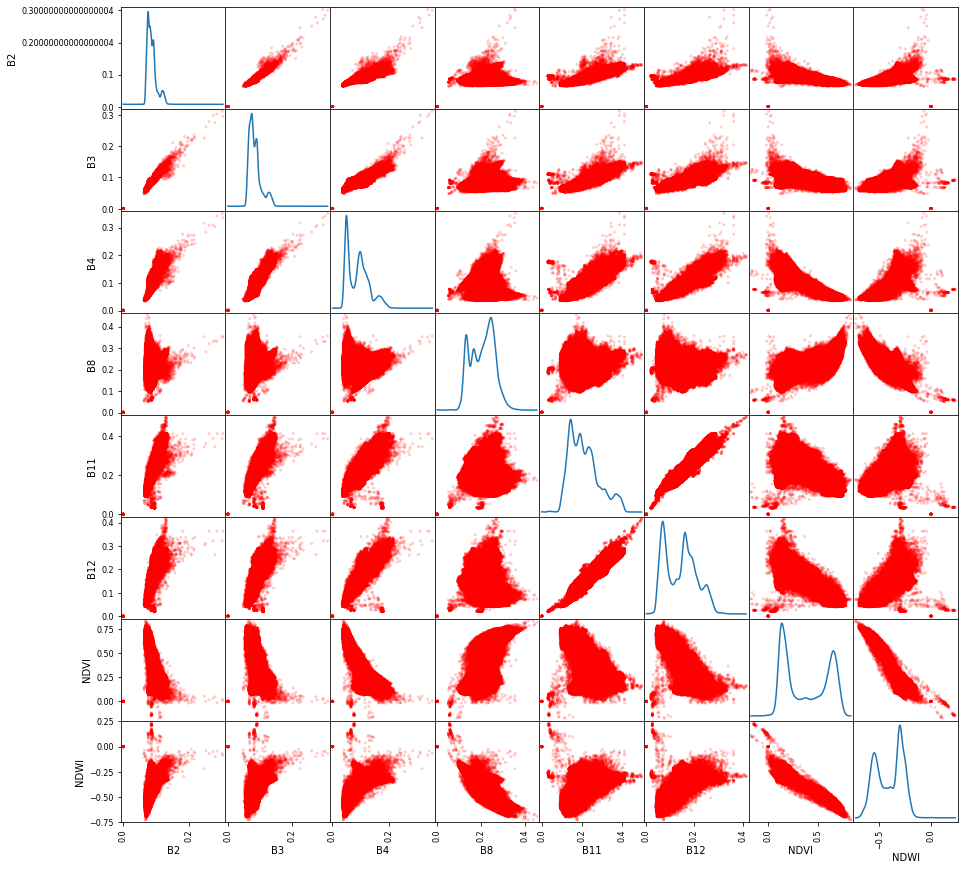

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(dfSland.compute(),alpha=0.2, figsize=(15,15),diagonal='kde',c='r')
plt.show()

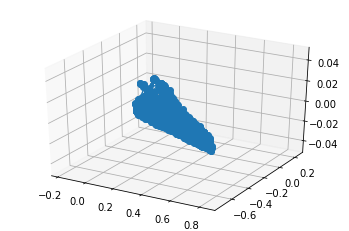

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = list(dfSland['NDVI'].compute())
y=  list(dfSland['NDWI'].compute())
ax.plot(x, y, zs=0, zdir='z',marker='o' )
plt.show()

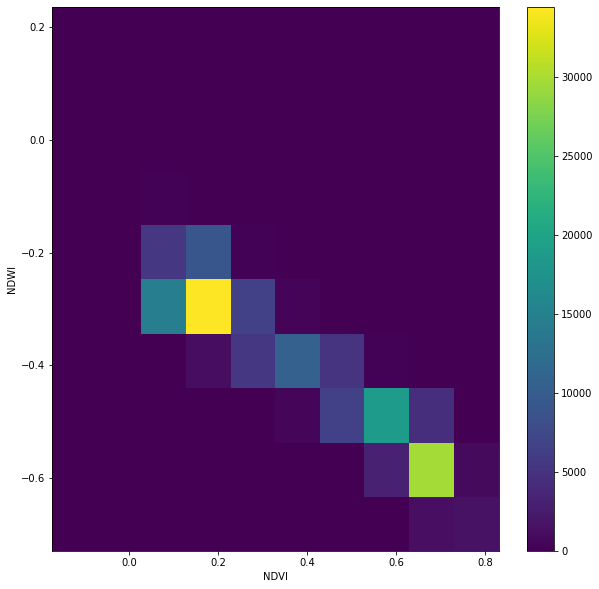

In [ ]:
plt.figure(figsize=(10, 10))
x = list(dfSland['NDVI'].compute())
y= list(dfSland['NDWI'].compute())
plt.xlabel('NDVI')
plt.ylabel('NDWI')
plt.grid(False)
plt.hist2d(x, y)
plt.colorbar()
plt.show()

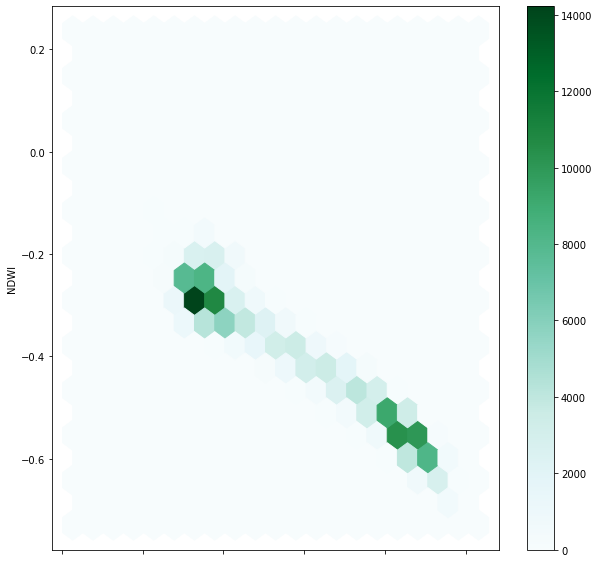

In [ ]:
dfSland.compute().plot(kind='hexbin', x='NDVI', y='NDWI',gridsize=20,figsize=(10, 10))
plt.show()

Now were going to split 20% of the data to reserve for testing  the quality of the trained model.

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

In [87]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.4. Part I - Random Forest Model fitting
<p style="text-align: justify">The classifier will be instantiated with default n_estimators = 100 (i.e. the forest will comprise 100 decision trees) and n_jobs = 1 (allowing for the use of 1 processing cores).</p>

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [88]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.00046882325363338024,
 1: 0.001597444089456869,
 2: 0.0004928536224741252,
 3: 1.970093973482535e-05,
 4: 0.000819000819000819,
 5: 1.5704257424187697e-05,
 6: 0.0002473410833539451,
 7: 0.0002824858757062147,
 8: 0.05263157894736842,
 9: 0.003115264797507788}

In [89]:
acc = []
model = []

In [90]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

In [93]:
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred, normalize=False)
print("Classification accuracy of RF is", rf_acc/len(y_test))

Classification accuracy of RF is 0.9223818278129187


In [95]:
rf_cm = np.zeros((10,10))
rf_pred_correct = 0
rf_pred_incorrect = 0
for i in range(len(y_test)):
    rf_index_test = y_test[i] - 1
    rf_index_pred = rf_pred[i] - 1
    rf_cm[rf_index_test][rf_index_pred] += 1
    if rf_index_test == rf_index_pred:
        rf_pred_correct += 1
    else:
        rf_pred_incorrect += 1

In [96]:
rf_cmatrix = pd.DataFrame(rf_cm.astype(int),
                          index = ['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize','Shadow','Sugarcane','Sunflower','Waterbody'],
                          columns = ['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize','Shadow','Sugarcane','Sunflower','Waterbody'])
rf_cmatrix

,Built,Cloud,Fallow,Forestland,Grassland,Maize,Shadow,Sugarcane,Sunflower,Waterbody
Built,74,0,3,0,43,15,0,0,0,1
Cloud,0,413,50,0,26,0,0,0,0,2
Fallow,0,21,12445,7,246,6,7,0,0,2
Forestland,0,0,16,137,94,0,7,0,0,0
Grassland,1,5,233,27,15201,53,435,0,0,6
Maize,9,0,24,0,524,467,5,0,0,11
Shadow,0,0,5,0,521,0,307,0,0,0
Sugarcane,0,0,0,0,2,0,0,1,0,0
Sunflower,0,0,1,0,0,0,0,0,73,0
Waterbody,0,1,0,0,77,5,0,0,0,484


In [98]:
m = metrics.accuracy_score(y_test, rf_pred)
acc.append(m)
model.append('Random Forest')
print("Random Forest's Accuracy is: ", m*100)

print(classification_report(y_test, rf_pred))

Random Forest's Accuracy is:  92.23818278129187
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       567
           1       0.88      0.54      0.67       136
           2       0.94      0.84      0.89       491
           3       0.97      0.98      0.98     12734
           4       0.80      0.54      0.64       254
           5       0.91      0.95      0.93     15961
           6       0.86      0.45      0.59      1040
           7       0.40      0.37      0.39       833
           8       1.00      0.33      0.50         3
           9       1.00      0.99      0.99        74

    accuracy                           0.92     32093
   macro avg       0.87      0.68      0.75     32093
weighted avg       0.92      0.92      0.92     32093



So 8 features have importance greater than 10% on predicting the cropland


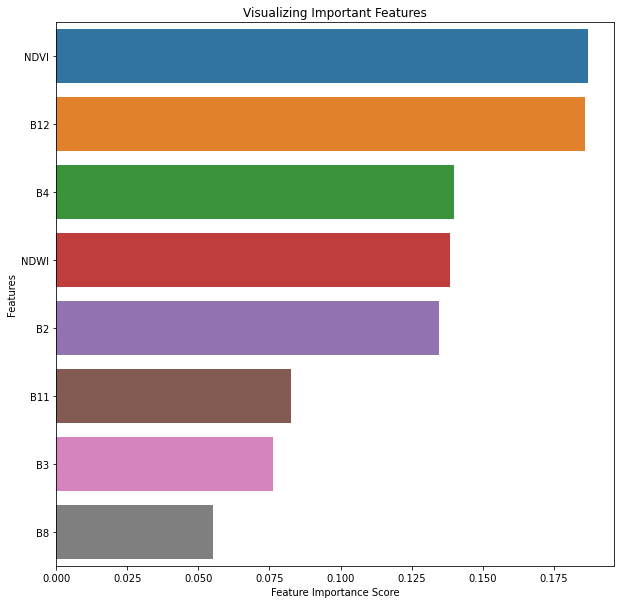

In [100]:
feature_cols = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI']
feature_imp = pd.Series(rf.feature_importances_,index=feature_cols).sort_values(ascending=False)
print("So", feature_imp[feature_imp >0.01].count(), 
      "features have importance greater than 10% on predicting the cropland")

#Creating a bar plot
fig, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### 4.4. Part II - Support Vector Machine Model fitting
<p style="text-align: justify">The classifier will be instantiated with default parameters.</p>

In [101]:
from sklearn.svm import SVC
svm = SVC()
svm = svm.fit(X_train, y_train)

In [102]:
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred, normalize=False)
print("Classification accuracy of RF is", svm_acc/len(y_test))

Classification accuracy of RF is 0.883276727012121


In [103]:
svm_cm = np.zeros((10,10))
svm_pred_correct = 0
svm_pred_incorrect = 0
for i in range(len(y_test)):
    svm_index_test = y_test[i] - 1
    svm_index_pred = rf_pred[i] - 1
    svm_cm[svm_index_test][svm_index_pred] += 1
    if svm_index_test == svm_index_pred:
        svm_pred_correct += 1
    else:
        svm_pred_incorrect += 1

In [104]:
svm_cmatrix = pd.DataFrame(svm_cm.astype(int),
                          index = ['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize','Shadow','Sugarcane','Sunflower','Waterbody'],
                          columns = ['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize','Shadow','Sugarcane','Sunflower','Waterbody'])
svm_cmatrix

,Built,Cloud,Fallow,Forestland,Grassland,Maize,Shadow,Sugarcane,Sunflower,Waterbody
Built,74,0,3,0,43,15,0,0,0,1
Cloud,0,413,50,0,26,0,0,0,0,2
Fallow,0,21,12445,7,246,6,7,0,0,2
Forestland,0,0,16,137,94,0,7,0,0,0
Grassland,1,5,233,27,15201,53,435,0,0,6
Maize,9,0,24,0,524,467,5,0,0,11
Shadow,0,0,5,0,521,0,307,0,0,0
Sugarcane,0,0,0,0,2,0,0,1,0,0
Sunflower,0,0,1,0,0,0,0,0,73,0
Waterbody,0,1,0,0,77,5,0,0,0,484


In [105]:
m = metrics.accuracy_score(y_test, svm_pred)
acc.append(m)
model.append('Support Vector Machine')
print("SVM's Accuracy is: ", m*100)

print(classification_report(y_test, svm_pred))

SVM's Accuracy is:  88.3276727012121
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       567
           1       0.00      0.00      0.00       136
           2       0.00      0.00      0.00       491
           3       0.94      0.96      0.95     12734
           4       0.00      0.00      0.00       254
           5       0.84      0.98      0.90     15961
           6       0.00      0.00      0.00      1040
           7       0.00      0.00      0.00       833
           8       0.00      0.00      0.00         3
           9       1.00      0.91      0.95        74

    accuracy                           0.88     32093
   macro avg       0.37      0.36      0.36     32093
weighted avg       0.81      0.88      0.84     32093



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


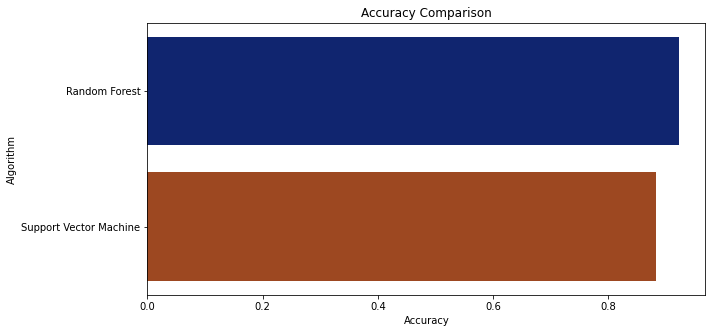

In [106]:
plt.figure(figsize=[10,5])
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc,y = model,palette='dark')